### III:

(1):

In [28]:
import re

def language_detector(text):
    greek_pattern = re.compile(r'\b[α-ωά-ώΆ-ΏίϊΐόύϋΰήΑ-ΩΊΪΌΎΫ\s]+\b', re.IGNORECASE)
    english_pattern = re.compile(r'\b[a-zA-Z\s]+\b', re.IGNORECASE)
    greeklish_pattern = re.compile(r'\b[α-ωά-ώΆ-Ώίϊΐόύϋΰήa-zA-Z\s]*'
                              r'(?:g|G|γ|Γ|th|TH|χ|Χ|ei|ou|th|ch|ph|ai|oi|ei|oi|si|ti|ri|ni|xi|psi|tsi|κ|Κ|άι|έι|όι|ού|υι|ευ|ηυ|αυ|άϊ|έϊ|ώϊ|οϊ|ϋι|ίς|ής|ος|ως|ας|ές|ής|ίς|ός|ύς|ώς|εί|αί|οί|ου|άς|ές|ής|ίς|ός|ύς|ώς|εί|αί|οί|ου|ά|έ|ή|ί|ό|ύ|ώ)?'
                              r'[a-zA-Z]+'
                              r'(?:is|aki|akis)?'
                              r'[a-zA-Z\s]*\b', re.IGNORECASE)


    greek_matches = greek_pattern.findall(text)
    english_matches = english_pattern.findall(text)
    greeklish_matches = greeklish_pattern.findall(text)

    greek_ratio = len(''.join(greek_matches)) / len(text)
    english_ratio = len(''.join(english_matches)) / len(text)
    greeklish_ratio = len(''.join(greeklish_matches)) / len(text)

    if greek_ratio > 0.5 and english_ratio < 0.2:
        return "Greek"
    elif english_ratio > 0.5 and greek_ratio < 0.2:
        return "English"
    elif greeklish_ratio > 0.5:
        return "Greeklish"
    else:
        return "Other"


In [29]:
import pandas as pd

df = pd.read_csv("../csv/gold.csv")
df

,text,orig_lang
0,Piece of cake - A,English
1,Cleft stick - In a,English
2,God rot them,English
3,Have an axe to grind,English
4,i couldn't care less if somebody's asking you ...,English
...,...,...
12885,"ഇത് വിലമതിക്കുന്നില്ല, നിങ്ങൾ റോക്ക് ചെയ്യുന്ന...",Other
12886,med sin enda dotter var narcisa marion extremt...,Other
12887,Nasıl' narsisizm artık marian onlara hem olan ...,Other
12888,Det är många vetenskapliga områden inom vilka ...,Other


In [30]:
df['orig_lang'].value_counts()

orig_lang
English      3683
Greek        3683
Greeklish    3683
Other        1841
Name: count, dtype: int64

To try and avoid situations where a given class is overrepresented or underrepresented, the parameter stratify will be used with value df['orig_lang'](labels).

The result is : 
       
          A random selection of the df['text'] values corresponding to the labels, but, the distribution of the original dataset is preserved in train and test sets.

Also, it should be noted that the Greeklish training data we have at hand is augmented information based on Greek proverbs, as discussed in the 'Create_Ground_Truth_Eval_Dataset.ipynb' notebook. Therefore, in a real-world scenario, to avoid misleading results, we should test the models with actual Greeklish data."

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np, warnings
from sklearn.exceptions import UndefinedMetricWarning


# Import a dataset with actual greek-english-greeklish crawled posts from HW5
second_df = pd.read_csv("../csv/f3352318.csv")
print(second_df['Language'].value_counts())




# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df["text"], df['orig_lang'],
                                                    stratify=df['orig_lang'], test_size=0.30, shuffle=True)
# print(X_train)
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=550)

# Fit and transform the text data
vec_train = tfidf_vectorizer.fit_transform(X_train)
vec_test = tfidf_vectorizer.fit_transform(X_test)

# Fit and transform the text data f3352318.csv
vec_test_2 = tfidf_vectorizer.fit_transform(second_df["Post/Reply"])

# Define a list of classifiers
classifiers = [
    RandomForestClassifier(),
    MultinomialNB(),
    LinearSVC(dual='auto'),
    LogisticRegression(max_iter=200),
    language_detector
]

# List to store the trained classifiers
trained_classifiers = []

# Iterate over each classifier
for classifier in classifiers:
    # Expecption for language_detector
    # requires different implementation 
    # against the other scikit models
    if classifier == language_detector:
        y_pred_ld = X_test.apply(language_detector)
        classification_rep = classification_report(y_test, y_pred_ld)
        print(f"Classification report for our LanguageDetector:\n{classification_rep}")
        break
    # Create an instance of the classifier
    clf = classifier
    
    
    # Fit the classifier on the transformed X_train and corresponding labels y_train
    clf.fit(vec_train, y_train)
    
    # Append the trained classifier to the list
    trained_classifiers.append(clf)
    
    # Predict on the test data
    y_pred = clf.predict(vec_test)
    
    # Get the name of the classifier for printing
    clf_name = type(classifier).__name__
    
    # Print the classification report
    classification_rep = classification_report(y_test, y_pred)
    print(f"Classification report for {clf_name}:\n{classification_rep}\n")

    
    
# Before the loop, add the following line to filter the warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print("\n\n////////Focus on Greeklish in the following classification reports////////\n\n")
# Perform the same classification for the f3352318.csv dataframe 
# Iterate over each classifier
for classifier in classifiers:
    # Expecption for language_detector
    # requires different implementation 
    # against the other scikit models
    if classifier == language_detector:
        y_pred_ld = second_df["Post/Reply"].apply(language_detector)
        classification_rep = classification_report(second_df.Language, y_pred_ld)
        print(f"Classification report for our LanguageDetector:\n{classification_rep}")
        break
    # Create an instance of the classifier
    clf = classifier
    
    
    # Fit the classifier on the transformed X_train and corresponding labels y_train
    clf.fit(vec_train, y_train)
    
    # Append the trained classifier to the list
    trained_classifiers.append(clf)
    
    # Predict on the test data
    y_pred = clf.predict(vec_test_2)
    
    # Get the name of the classifier for printing
    clf_name = type(classifier).__name__
    
    # Print the classification report
    classification_rep = classification_report(second_df.Language, y_pred)
    print(f"Classification report for {clf_name}:\n{classification_rep}\n")

Language
Greeklish    55
English      31
Name: count, dtype: int64
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

     English       0.53      0.71      0.61      1105
       Greek       1.00      0.86      0.92      1105
   Greeklish       0.70      0.55      0.62      1105
       Other       0.51      0.51      0.51       552

    accuracy                           0.68      3867
   macro avg       0.68      0.66      0.67      3867
weighted avg       0.71      0.68      0.69      3867


Classification report for MultinomialNB:
              precision    recall  f1-score   support

     English       0.52      0.74      0.61      1105
       Greek       1.00      0.88      0.94      1105
   Greeklish       0.71      0.45      0.55      1105
       Other       0.51      0.56      0.54       552

    accuracy                           0.67      3867
   macro avg       0.69      0.66      0.66      3867
weighted avg       0.71   

First of all, the second series of classifictaions reports incate that the models even though they are trained on a augmented Greeklish data, it seems somewhat capable of labeling correctly the Greeklish. This is just a note to the address the point we talked in the online call!

In terms of accuracy the Random Forest Classifier, Multinomial Naive Bayes and Logistic Regression are the top performing models here, with Random Forests Classifier standing out the most.


It is also evident that, all the models perform extremely efficient when classifing the Greek language based on the precision, recall and f1-score metrics. This might be, because the Greek letters are in general differenciable from other languages that have latin characters like English and Greeklish,  exluding other languages who do use unique symbols.

Regarding the precision macro average, the Multinomial Naive Bayes has the highest value,with Random Forest a close second, indicating that among the 4 classes this classifier has the highest ratio of correctly predicted positive observations from the total predicted positives.

In contrast to the previous, in terms of macro average for recall, the Multinomial Naive Bayes classifier has an equal value to Random Forests Classifier with both having the highest value indicating that among the 4 classes this classifier is able to capture the largest amount of correctly predicted positives.

Now, in terms of f1-score macro average, this metric reached the highest value for Random Forests which indicates that the precision and recall balanced out the best among those two classifiers.

So, in general, the Random Forest Classifier is found at the top of most of the metrics we used. At this point, we confidently say that Random Forest Classifier the best perfoming model here.






(2):

In [54]:
import pandas as pd

text = pd.read_csv("../csv/crawl.csv")
print(text.columns)


Index(['page_title', 'comments', 'url', 'date', 'pred_lang'], dtype='object')


In [55]:
# Diplay a portion
text[:5]

,page_title,comments,url,date,pred_lang
0,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Μλκα ειναι αστείο αυτό το άρθρο ειδικά για εμά...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Other
1,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Έκλαψα και ο χαγιατε συνεχίζει τις εκπομπές κα...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-22,Other
2,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Επόμενο live hayate: Τρελό μακελειό με δυνάμει...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Greek
3,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,γελάμε με τον ίδιο τρόπο εντωμεταξύ γάματα,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Greek
4,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,μου αρέσει που γελάς και γελάνε και άλλοι μαζί...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-19,English


In [56]:
# Search for NaN values
print(f"Number of NaN values: {text.comments.isna().sum().sum()}")
print(f"They appear as :\n {text[text.comments.isna()]}")

Number of NaN values: 0
They appear as :
 Empty DataFrame
Columns: [page_title, comments, url, date, pred_lang]
Index: []


In [57]:
# Drop NaN values
text = text.dropna().reset_index()
print(text.comments.isna().sum().sum())

0


In [59]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=550)
# Transorm out text data to matrixes with TF-IDF transformer
vec_comments = tfidf_vectorizer.fit_transform(text["comments"])
print(vec_comments.shape)
# Extract the trained Naive Bayes Classifier
nb = trained_classifiers[1]


# Predict the language of the comments
text.loc[:, "pred_lang"] = nb.predict(vec_comments)

# Drop the indexing column as it no needed 
text = text.drop(columns='index')
# Display final dataframe
text[:3]

(281, 550)


,page_title,comments,url,date,pred_lang
0,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Μλκα ειναι αστείο αυτό το άρθρο ειδικά για εμά...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Other
1,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Έκλαψα και ο χαγιατε συνεχίζει τις εκπομπές κα...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-22,English
2,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Επόμενο live hayate: Τρελό μακελειό με δυνάμει...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Greek


In [60]:
text.to_csv("../csv/crawl.csv", index=False)

In [61]:
"""# Find the row with 'Greeklish' in the 'pred_lang' column and index 29
desired_row = text[(text['pred_lang'] == 'Greeklish') & (text.index == 29)]

# Set the maximum width for column 'comments'
pd.set_option('display.max_colwidth', None)

# Display the result
print(desired_row)"""
text[text.pred_lang == 'Greeklish'][:30]

,page_title,comments,url,date,pred_lang
16,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Βρήκα το βίντεο με το τέστ IQ. Έβγαλε 62 ο Βάρ...,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Greeklish
19,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Μακαρι να μπει μεσα και ο φλοριαν ο hayate,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Greeklish
20,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Υπάρχει φυλάκιση καθως και για σενα,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-21,Greeklish
22,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Πάμε Γερά Lotof,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Greeklish
28,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Oxi polu fulakh eleos dld hahahah,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-18,Greeklish
37,Το ΜΑΚΕΛΕΙΟ Προσπαθεί Να Μπλέξει Και Τον HAYATE?,Φάτε μπέργκερ μάγκες!!,https://www.youtube.com/watch?v=vSMMBjg_CKc,2023-11-19,Greeklish
53,"ΕΚΑΨΕ ΕΓΚΕΦΑΛΟ ο Τρύφωνος, με τύπο που ακούει ...",Πιο ξινός και από λεμόνι 🫠,https://www.youtube.com/watch?v=gf2BG6ZFe2A,2023-11-28,Greeklish
54,"ΕΚΑΨΕ ΕΓΚΕΦΑΛΟ ο Τρύφωνος, με τύπο που ακούει ...",Αυτο το τσουπ ολα τα λεφτά,https://www.youtube.com/watch?v=gf2BG6ZFe2A,2023-11-28,Greeklish
69,ΑΜΕΤΑΝΟΗΤΟΣ Μπέος βγαίνει στον ΑΝΤ1 και τα ΞΑΝ...,Μπράβο ρε Άντρα!!!! Μόνο εσύ,https://www.youtube.com/watch?v=X1ev3RxDnNI,2023-11-28,Greeklish
74,ΑΜΕΤΑΝΟΗΤΟΣ Μπέος βγαίνει στον ΑΝΤ1 και τα ΞΑΝ...,Μπραβο Λουμπεν!¡!,https://www.youtube.com/watch?v=X1ev3RxDnNI,2023-11-28,Greeklish


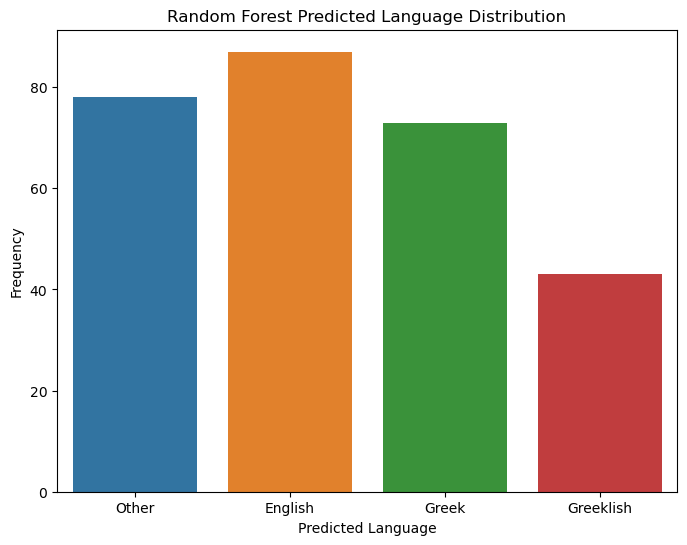

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'pred_lang' contains the predicted language labels
plt.figure(figsize=(8, 6))
sns.countplot(x='pred_lang', data=text)
plt.xlabel('Predicted Language')
plt.ylabel('Frequency')
plt.title('Random Forest Predicted Language Distribution')
plt.show()

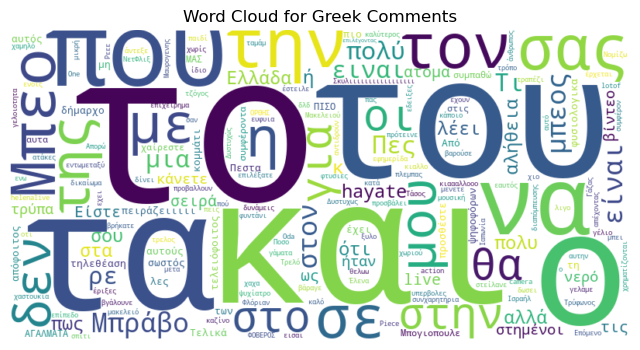

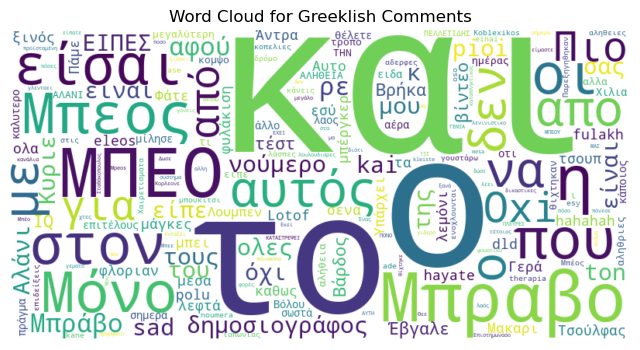

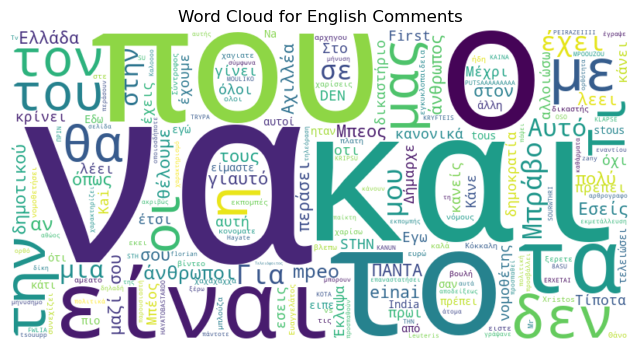

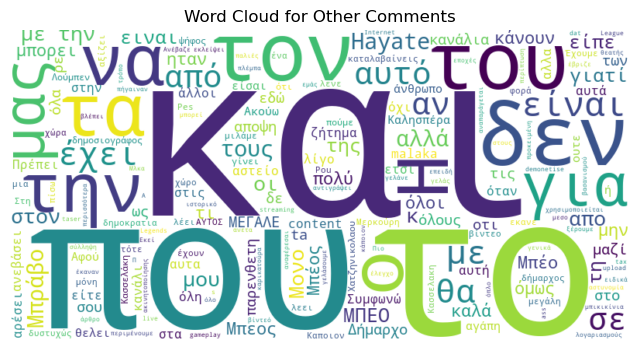

In [63]:
from wordcloud import WordCloud
# Assuming 'comments' contains the text comments
for lang in ['Greek', 'Greeklish', 'English', 'Other']:
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text.loc[text['pred_lang'] == lang, 'comments']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {lang} Comments')
    plt.show()